In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
import numpy as np
from datasets import load_dataset
import torch
from tqdm import tqdm

In [2]:
set_seed(0)

model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
alpaca_eval = load_dataset("tatsu-lab/alpaca_eval", "alpaca_eval")["eval"]

/data/oam_patel/miniconda3/envs/itc/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for tatsu-lab/alpaca_eval contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tatsu-lab/alpaca_eval
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


(array([488., 176.,  64.,  28.,  13.,  10.,  10.,   2.,   1.,   2.,   7.,
          0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   1.]),
 array([  9.,  33.,  57.,  81., 105., 129., 153., 177., 201., 225., 249.,
        273., 297., 321., 345., 369., 393., 417., 441., 465., 489.]),
 <BarContainer object of 20 artists>)

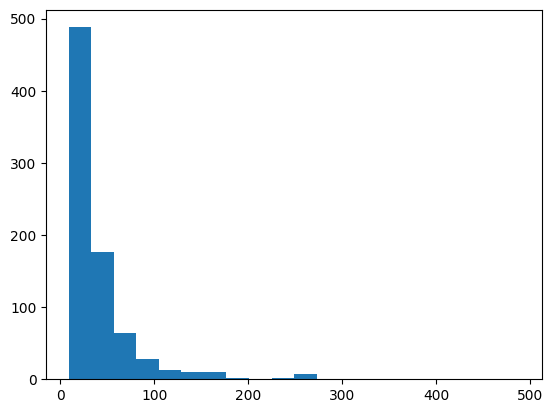

In [9]:
prompts = alpaca_eval['instruction']
messages = [[{"role": "user", "content": p}] for p in prompts]
inputs = tokenizer.apply_chat_template(messages, tokenize=True)
lens = [len(i) for i in inputs]

import matplotlib.pyplot as plt
plt.hist(lens, bins=20)

In [48]:
def batched_generate_n(model, tokenizer, prompts, n, batch_size=8, max_new_tokens=256, temperature=1, device='cuda'): 
    
    model = model.to(device)
    model.eval()
    
    generated = []
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch = prompts[i:i+batch_size]
        batch = [[{"role": "user", "content": p}] for p in batch]
        inputs = tokenizer.apply_chat_template(batch, tokenize=True, padding=True, return_tensors="pt").to(device)
        attn_mask = torch.ones_like(inputs).to(device)
        attn_mask[inputs == tokenizer.pad_token_id] = 0
        outputs = model.generate(inputs, attention_mask=attn_mask, max_new_tokens=max_new_tokens, num_return_sequences=n, temperature=temperature)
        outputs = outputs[:, inputs.shape[1]+5:]
        outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        for j in range(len(batch)):
            generated.append(outputs[j*n:(j+1)*n])
    return generated
        
    

In [49]:
generated = batched_generate_n(model, tokenizer, alpaca_eval['instruction'][:2], n=2)

100%|██████████| 1/1 [00:08<00:00,  8.49s/it]


In [50]:
generated

[['Many famous actors got their start on Broadway before making it big in Hollywood. Here are some examples:\n\n1. Julie Andrews: Andrews made her Broadway debut in 1954 in "The Boy Friend" and went on to star in "My Fair Lady" and "Camelot" before winning the Oscar for "Mary Poppins."\n2. Gene Kelly: Kelly started his career on Broadway in the 1930s, appearing in shows like "Leave It to Me!" and "Pal Joey" before becoming a movie star in the 1940s and \'50s.\n3. Jack Lemmon: Lemmon began his career on Broadway in the 1940s, appearing in shows like "Room Service" and "Operation Mad Ball." He later became a film star, known for his collaborations with director Billy Wilder.\n4. Shirley MacLaine: MacLaine made her Broadway debut in 1956 in "Wild Is the Wind" and went on to star in "The Full Monty" and "Applause" before becoming a film star in the 1960s and \'70s.\n5. Alan Alda: Alda started his career on Broadway in the 1950s, appearing in shows like "',
  'Many famous actors got their s

In [29]:
generated[2]

tensor([128000, 128006,    882, 128007,    271,   4438,   1550,   2326,   5415,
           636,    872,   5144,     30, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128006, 128006,  78191, 128007,    271,   3923,
           264,   2294,   3488,      0,    578,  33472,    315,   2326,   1614,
          5144,    527,  27387,    323,   3629,   8881,    279,   3925,     11,
         54242,     11,    323,  13042,  28948,    315,   1855,   5654,     13,
          5810,    596,    264,  10015,  95748,   1473,    334,  21464,   3778,
         34453,     25,  57277,      9,  28366,     25,  68949,    505,    279,
         19623,    332,   3492,    330,    278,    710,     82,   9786,     80,
          1359,   7438,    330,   3902,   1974,      1,    477,    330,  29526,
         10246,      9,  17368,     25,  54328,    505,    279,    393,   7675,
         17118,   3778,  34671,    596,   3492,    330,    278,    128,    255,
         87189,    117,     96,    263, 